<a href="https://colab.research.google.com/github/Alighiamy/Beam-analysis/blob/main/Euler%E2%80%93Bernoulli_beam_theory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_in this version we can define both uniform distributed load and concentraited load:_

In [ ]:
%reset-f
import numpy as np
import sympy as sym
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Inputs:
# ______________________________________________________________________________
# Material Properties:
Emudul = 2e5
ν = 0.3
Gmudul = Emudul/(2*(1 + ν))
ρ = 7850 # Density
# ..............................................................................
# Geometic Properties:
by = 0.4 # wigth of the Beam in y direction (mm)
hz = 0.4 # Hight of Beam in z direction (mm)
LB = 100 # Length of the Beam in x direction (mm) 

Asurf= by*hz # (mm^2)
Inersia = by*hz**3/12 # (mm^4)
# ..............................................................................
ElemN = 2 # Number of Beam Elements

Le = LB/ElemN # Length of Each Element
# ..............................................................................
# Load: Kind of Load Distribution: [Con: Concentrated Load, Uni: Uniform distribution]
q = -1 # Load Amplitude (N)
Load_dist = 'Uni' # [Con : Uni]
LoadDistance = 1*LB/2
# ------------------------------------------------------------------------------
# Boundary Condition: [c: Clamped, s: Simply, f: Free]
BCL = 's' # [s : c : f] Left
BCR = 's' # [s : c : f] Right

In [ ]:
# Euler–Bernoulli beam theory:
DPN = 3 # Degree of Freedom per Node (u, v=dw/dx , w)
NPE = 2 # Node per Elements

DPE = DPN*NPE # Degree of Freedom per element
NodeN = ElemN+1 # Number of All Nodes
DOFs = NodeN*DPN

_Material Properties:_

Equations:

$Q_{2\times2} =
 \begin{pmatrix}
  \varphi_{1,1} & 0 \\
             0  & \varphi_{3,3}
 \end{pmatrix}=$
$\begin{pmatrix}
  EA & 0 \\
            0  & EI
  \end{pmatrix}$
 
 $\begin{pmatrix}
 F_{x}\\
 M_{y}
\end{pmatrix}=
  \begin{pmatrix}
  \varphi_{1,1} & 0 \\
             0  & \varphi_{3,3}
\end{pmatrix}. 
  \begin{pmatrix}
  \epsilon^{0}_{xx}\\
  \epsilon^{1}_{xx}
\end{pmatrix}$

In [ ]:
# Sttifnees Material property Matirx
#===============================================================================
φ=np.zeros((2,2),dtype=float)
#...............................................................................
# Isotropic:

φ[0][0] = Emudul*Asurf # (N)
φ[1][1] = Emudul*Inersia # (N.mm)

print(φ)

[[32000.             0.        ]
 [    0.           426.66666667]]


In [ ]:
# Shape Functions and their differntation
x = sym.Symbol('x')
N1 = 1 - x/Le
N2 = x/Le
dxN1 = sym.diff(N1, x, 1)
dxN2 = sym.diff(N2, x, 1)

H1 = (1/Le**3) * (Le**3 - 3*Le*x**2 + 2*x**3)
dx1H1 = sym.diff(H1, x, 1)
dx2H1 = sym.diff(H1, x, 2)

H2 = (1/Le**2) * (Le**2*x - 2*Le*x**2 + x**3)
dx1H2 = sym.diff(H2, x, 1)
dx2H2 = sym.diff(H2, x, 2)

H3 = (1/Le**3) * (3*Le*x**2 - 2*x**3)
dx1H3 = sym.diff(H3, x, 1)
dx2H3 = sym.diff(H3, x, 2)

H4 = (1/Le**2) * (x**3 - Le*x**2)
dx1H4 = sym.diff(H4, x, 1)
dx2H4 = sym.diff(H4, x, 2)

###${ϵ}=B.𝚫$->$
\begin{pmatrix}
\epsilon^{0}_{xx}\\
\epsilon^{1}_{xx}
\end{pmatrix}=
  \begin{pmatrix}
  \frac{du}{dx}\\
  \frac{d^{2}w}{dx^{2}}
  \end{pmatrix}$


$=>$__Sttifness Matrix of Element:__$\begin{align}
K_{e}=\int_{0}^{L_{e}} B^{T}.Q.B\mathrm{d}x \
\end{align}$

In [ ]:
#                  u1    w1     θ1    u2     w2      θ2
B = sym.Matrix([[dxN1,     0,     0, dxN2,     0,     0],
               [    0, dx2H1, dx2H2,    0, dx2H3, dx2H4]])
B_T = B. transpose()

KE = sym.integrate(B_T @ φ @ B, (x, 0, Le))
# KE

__Geometric Sttifness Matrix of Element:__

$\begin{align}
K_{Ge}=\int_{0}^{L_{e}} B_{g}^{T}B_{g}\mathrm{d}x \
\end{align}$

In [ ]:
Bg = sym.Matrix([[    0, dx2H1, dx2H2,    0, dx2H3, dx2H4]])
Bg_T = Bg. transpose()

KGE = sym.integrate(Bg_T @ Bg, (x, 0, Le))
# KGE

__Force Vector of each Element:__
_This is defined for uniform load ditribution_

$\begin{align}
F_{e}=\int_{0}^{L_{e}} N_{e}^{T}q(x)\mathrm{d}x \
\end{align}$

In [ ]:
Ne = sym.Matrix([[    0, H1, H2,    0, H3, H4]])
Ne_T = Ne. transpose()
if Load_dist == 'Uni':
  FE = sym.integrate(Ne_T * q, (x, 0, Le))
elif Load_dist == 'Con':
  Force_E = sym.zeros(DPE,ElemN)
  FE = Ne_T * q
  FE = FE.subs(x,Le)
  for i in range(ElemN):
    if (0+i*Le) <= LoadDistance < (Le+i*Le):
      ConLoadElem = ElemN
      Force_E[:,i] = FE
      FE = Force_E
# FE

__Mass Matrix of each Element:__

$\begin{align}
M_{e}=\int_{0}^{L_{e}} N_{e}^{T}.ρ.N_{e}\mathrm{d}x \
\end{align}$

In [ ]:
Ne = sym.Matrix([[    0, H1, H2,    0, H3, H4]])
Ne_T = Ne. transpose()

ME = sym.integrate(ρ*Ne_T @ Ne, (x, 0, Le))
# ME

In [ ]:
DCON = np.zeros([ElemN,DPE],dtype=int)
DOF_list = list(range(1,DOFs+1))

for j in range(ElemN):
    for i in range(DPE):
        DCON[j][i] = DOF_list [i+DPN*j]

# Using pandas to creat a table of DCON
dCon = pd.DataFrame(
    DCON,
    index=list(range(1,ElemN+1)),
    columns=['u1', 'w1', 'θ1','u2','w2','θ2'])
dCon.tail()

,u1,w1,θ1,u2,w2,θ2
1,1,2,3,4,5,6
2,4,5,6,7,8,9


In [ ]:
# Boundary Condition:
# Left BC:
dof_left = []
if BCL == 's':
  dof_left = DCON[0][[0,1]]-1
elif BCL == 'c':
  dof_left = DCON[0][[0,1,2]]-1
elif BCL == 'f':
  dof_left = np.array([])
#-------------------------------------------------------------------------------
# Right BC:
dof_right = []

if BCR == 's':
  dof_right = DCON[-1][[-2,-3]]-1
elif BCR == 'c':
  dof_right = DCON[-1][[-1,-2,-3]]-1
elif BCR == 'f':
  dof_right = np.array([])
#-------------------------------------------------------------------------------
bc_sort = []
bc_sort = np.concatenate((dof_right, dof_left))
bc_sort = np.sort(bc_sort)[::-1]
# bc_sort = sym.Matrix(bc_sort)

In [ ]:
# Calculation Total Sttifness Matirix
KT = sym.Matrix(np.zeros([DOFs,DOFs],dtype=float))
for k in range(ElemN):
    for i in range(DPE):
        for j in range(DPE):
            KT[DCON[k][i]-1,DCON[k][j]-1] += KE[i,j]
#-------------------------------------------------------------------------------
# Column Deleting
KT = np.delete(KT, bc_sort, axis=1)
# Row Deleting
KT = np.delete(KT, bc_sort, axis=0)
KT = sym.Matrix(KT)
# KT

In [ ]:
KT

Matrix([
[34.1333333333334,      0,               -1.024,     17.0666666666667,              0.0],
[               0, 1280.0,                    0,                    0,                0],
[          -1.024,      0,              0.08192, 4.44089209850063e-16,            1.024],
[17.0666666666667,      0, 4.44089209850063e-16,     68.2666666666667, 17.0666666666667],
[             0.0,      0,                1.024,     17.0666666666667, 34.1333333333333]])

In [ ]:
# Calculation Total Force Vector
if Load_dist == 'Uni':
  FT = sym.Matrix(np.zeros([DOFs,1],dtype=float))
  for k in range(ElemN):
    for i in range(DPE):
        FT[DCON[k][i]-1] += FE[i]
elif Load_dist == 'Con':
  FT = sym.Matrix(np.zeros([DOFs,1],dtype=float))
  for k in range(ElemN):
    for i in range(DPE):
      FT[DCON[k][i]-1] += FE[i,k]

FT = np.delete(FT, bc_sort)
FT = sym.Matrix(FT)
# FT

###$F = K. 𝚫=>𝚫 = K^{-1}.F$


In [ ]:
# Nodal Displacement:
NodalDip = KT.inv()@FT
# NodalDip

In [ ]:
if BCL == 's':
  NodalDip1 = np.delete(NodalDip, [0,-1])
  Wmax_Nodes = [0]
  for i in range(NodeN-2):
      Wmax_Nodes.append(NodalDip1[1+3*i])
  Wmax_Nodes.append(0)
elif BCL == 'c':
  Wmax_Nodes = [0]
  for i in range(NodeN-2):
      Wmax_Nodes.append(NodalDip[1+3*i])
  Wmax_Nodes.append(0)

In [ ]:
np.max(np.abs(Wmax_Nodes))

3051.75781249999

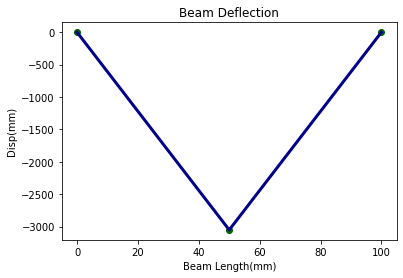

In [ ]:
Y = Wmax_Nodes
X =list(range(0,LB+int(Le),int(Le)))
plt.scatter(X, Y, color='darkgreen')
plt.plot(X, Y, color='darkblue', linewidth=3)
plt.title('Beam Deflection')
plt.ylabel('Disp(mm)')
plt.xlabel('Beam Length(mm)')
plt.show()